# Pre-Activation Residual Autoencoder Training (Variant B)

Training the Pre-Activation Residual Autoencoder for SAR image compression.

**Model Architecture:**
- Pre-activation residual blocks (BN->ReLU->Conv ordering)
- 4 encoder stages with 2 blocks each (8 total)
- 4 decoder stages with bilinear upsample + 1x1 conv
- ~6M parameters (base_channels=32)

**Configuration (v3 - with stability improvements):**
- Loss weights: 0.7 MSE + 0.3 SSIM (emphasize pixel accuracy for PSNR)
- Learning rate: 5e-5 with 3-epoch linear warmup
- Optimizer: AdamW with weight_decay=1e-5
- Gradient clipping: 0.5 (more aggressive)
- 30 epochs, batch size 16 with AMP
- 20% data subset for fair comparison with baseline

**Targets:**
- PSNR >= 22.0 dB (baseline: 20.47 dB, +1.5 dB improvement)
- ENL ratio: 0.7-1.3

**Comparison:**
| Model | Params | PSNR | SSIM |
|-------|--------|------|------|
| Baseline | 2.3M | 20.47 dB | 0.646 |
| ResNet-Lite v2 | 5.6M | 21.20 dB | 0.726 |
| Residual v2 | 6.0M | 19.78 dB | 0.578 |
| **Residual v3** | 6.0M | ? | ? |

## 1. Setup and Imports

In [ ]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

In [5]:
import torch
import torch.nn as nn

# Project imports
from src.data.datamodule import SARDataModule
from src.models import ResidualAutoencoder  # Variant B - Pre-Activation Residual
from src.losses.combined import CombinedLoss
from src.training.trainer import Trainer

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

AttributeError: module 'numpy._core' has no attribute '_multiarray_umath'

## 2. Configuration

In [ ]:
# ============================================================
# CONFIGURATION - Pre-Activation Residual Autoencoder (Variant B)
# ============================================================

# =========================
# TRAINING MODE
# =========================
QUICK_SEARCH = True  # True = 10% data, 20 epochs (hyperparameter search)
                      # False = 20% data, 30 epochs (full training)

# Data settings
DATA_PATH = "D:/Projects/CNNAutoencoderProject/data/patches/metadata.npy"
BATCH_SIZE = 16       # With AMP - adjust if OOM
NUM_WORKERS = 0       # Parallel data loading
VAL_FRACTION = 0.1    # 10% validation split
TRAIN_SUBSET = 0.10 if QUICK_SEARCH else 0.20

# Model settings - Full ResidualAutoencoder
LATENT_CHANNELS = 16  # 16 = 16x compression
BASE_CHANNELS = 32    # Reduced from 64 for 8GB VRAM constraint

# Loss settings (per CONTEXT.md: 0.7 MSE + 0.3 SSIM for PSNR emphasis)
MSE_WEIGHT = 0.7
SSIM_WEIGHT = 0.3

# Training settings - with stability improvements
EPOCHS = 20 if QUICK_SEARCH else 30
LEARNING_RATE = 5e-5      # With warmup for stability
WARMUP_EPOCHS = 3         # Linear warmup
OPTIMIZER = 'adamw'       # AdamW handles weight decay better
WEIGHT_DECAY = 1e-5       # Regularization
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 5
LR_FACTOR = 0.5
MAX_GRAD_NORM = 0.5       # More aggressive clipping
USE_AMP = True            # Mixed precision for faster training

# Output settings
mode_suffix = "quick" if QUICK_SEARCH else "full"
RUN_NAME = f"residual_v3_{mode_suffix}_c{LATENT_CHANNELS}"

# Calculate compression ratio
compression_ratio = (256 * 256) / (16 * 16 * LATENT_CHANNELS)
print(f"{'='*60}")
print(f"MODE: {'QUICK SEARCH (10% data, 20 epochs)' if QUICK_SEARCH else 'FULL TRAINING (20% data, 30 epochs)'}")
print(f"{'='*60}")
print(f"Model: Pre-Activation ResidualAutoencoder (Variant B)")
print(f"Base channels: {BASE_CHANNELS}")
print(f"Compression ratio: {compression_ratio:.0f}x")
print(f"Training subset: {TRAIN_SUBSET*100:.0f}% of data")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Loss weights: MSE={MSE_WEIGHT}, SSIM={SSIM_WEIGHT}")
print(f"Learning rate: {LEARNING_RATE} with {WARMUP_EPOCHS} epoch warmup")
print(f"Optimizer: {OPTIMIZER.upper()} (weight_decay={WEIGHT_DECAY})")
print(f"Gradient clipping: {MAX_GRAD_NORM}")
print(f"Run name: {RUN_NAME}")

### Training Stability Tips

If you experience training instability (NaN losses, divergence) with higher learning rates, try these approaches:

**1. Learning Rate Warmup** (Recommended)
```python
# Add to trainer config or implement custom scheduler
WARMUP_EPOCHS = 3  # Start at LR/10, linearly increase to LR
```

**2. Cosine Annealing Schedule**
```python
# Replace ReduceLROnPlateau with CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
```

**3. Lower Gradient Clipping**
```python
MAX_GRAD_NORM = 0.5  # Try 0.5 instead of 1.0 for more aggressive clipping
```

**4. AdamW with Weight Decay**
```python
# AdamW handles weight decay better than Adam
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
```

**5. Gradient Accumulation** (if batch size is limited)
```python
# Simulate larger batch by accumulating gradients over N steps
ACCUMULATION_STEPS = 2  # Effective batch = BATCH_SIZE * 2
```

**Current issue**: Learning rate 1e-5 is too conservative, leading to underfitting. Try 3e-5 or 5e-5 with warmup.

## 3. Load Data

In [ ]:
print("Loading data...")
dm = SARDataModule(
    patches_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_fraction=VAL_FRACTION,
)

# Apply subset to BOTH train and val for faster iteration
if TRAIN_SUBSET < 1.0:
    import random
    
    # Subset training data
    full_train_size = len(dm.train_dataset)
    train_subset_size = int(full_train_size * TRAIN_SUBSET)
    train_indices = random.sample(range(full_train_size), train_subset_size)
    dm.train_dataset = torch.utils.data.Subset(dm.train_dataset, train_indices)
    
    # Subset validation data (same proportion)
    full_val_size = len(dm.val_dataset)
    val_subset_size = int(full_val_size * TRAIN_SUBSET)
    val_indices = random.sample(range(full_val_size), val_subset_size)
    dm.val_dataset = torch.utils.data.Subset(dm.val_dataset, val_indices)
    
    print(f"Using {TRAIN_SUBSET*100:.0f}% subset:")
    print(f"  Train: {train_subset_size:,} of {full_train_size:,}")
    print(f"  Val: {val_subset_size:,} of {full_val_size:,}")

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

print(f"\nDataset loaded:")
print(f"  Train patches: {len(dm.train_dataset):,}")
print(f"  Val patches: {len(dm.val_dataset):,}")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches: {len(val_loader):,}")
print(f"  Preprocessing params: {dm.preprocessing_params}")

# Estimate epoch time (larger model = slower)
est_batches = len(train_loader) + len(val_loader)
est_time_min = est_batches / 1.0 / 60  # ~1.0 it/s with larger model
print(f"\n  Estimated time per epoch: ~{est_time_min:.0f} minutes")

Loading data...
Loading metadata from D:\Projects\CNNAutoencoderProject\data\patches\metadata.npy
Total patches: 696277
Train: 626650, Val: 69627
Using 20% subset:
  Train: 125,330 of 626,650
  Val: 13,925 of 69,627

Dataset loaded:
  Train patches: 125,330
  Val patches: 13,925
  Train batches: 7,833
  Val batches: 871
  Preprocessing params: {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}

  Estimated time per epoch: ~145 minutes


In [ ]:
# Verify a sample batch
sample_batch = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Sample batch dtype: {sample_batch.dtype}")
print(f"Sample batch range: [{sample_batch.min():.4f}, {sample_batch.max():.4f}]")

Sample batch shape: torch.Size([16, 1, 256, 256])
Sample batch dtype: torch.float32
Sample batch range: [0.0000, 1.0000]


## 4. Create Model

In [ ]:
print("Creating Pre-Activation Residual Autoencoder...")
model = ResidualAutoencoder(
    latent_channels=LATENT_CHANNELS,
    base_channels=BASE_CHANNELS,
)

params = model.count_parameters()
print(f"\nModel created:")
print(f"  Architecture: ResidualAutoencoder (Variant B)")
print(f"  Total parameters: {params['total']:,}")
print(f"  Encoder params: {params['encoder']:,}")
print(f"  Decoder params: {params['decoder']:,}")
print(f"  Compression ratio: {model.get_compression_ratio():.1f}x")
print(f"  Latent size: {model.get_latent_size()}")

# Compare to other models
baseline_params = 2_257_809
resnet_lite_params = 5_648_033
print(f"\n  vs Baseline: {params['total'] / baseline_params:.1f}x more parameters")
print(f"  vs ResNet-Lite: {params['total'] / resnet_lite_params:.1f}x more parameters")

Creating Pre-Activation Residual Autoencoder...

Model created:
  Architecture: ResidualAutoencoder (Variant B)
  Total parameters: 5,992,673
  Encoder params: 2,805,760
  Decoder params: 3,186,913
  Compression ratio: 16.0x
  Latent size: (16, 16, 16)

  vs Baseline: 2.7x more parameters
  vs ResNet-Lite: 1.1x more parameters


In [ ]:
# Test forward pass
print("Testing forward pass...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_test = model.to(device)
x_test = sample_batch[:2].to(device)

with torch.no_grad():
    x_hat, z = model_test(x_test)

print(f"  Input: {x_test.shape}")
print(f"  Latent: {z.shape}")
print(f"  Output: {x_hat.shape}")
print(f"  Output range: [{x_hat.min():.4f}, {x_hat.max():.4f}]")

# Check GPU memory
if torch.cuda.is_available():
    print(f"  GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

# Clean up test
del model_test, x_test, x_hat, z
torch.cuda.empty_cache()

Testing forward pass...
  Input: torch.Size([2, 1, 256, 256])
  Latent: torch.Size([2, 16, 16, 16])
  Output: torch.Size([2, 1, 256, 256])
  Output range: [0.0000, 1.0000]
  GPU memory allocated: 0.02 GB


## 5. Create Loss Function

In [ ]:
loss_fn = CombinedLoss(
    mse_weight=MSE_WEIGHT,
    ssim_weight=SSIM_WEIGHT,
)

print(f"Loss function: CombinedLoss")
print(f"  MSE weight: {MSE_WEIGHT} (emphasize pixel accuracy)")
print(f"  SSIM weight: {SSIM_WEIGHT}")
print(f"  Formula: L = {MSE_WEIGHT} * MSE + {SSIM_WEIGHT} * (1 - SSIM)")

Loss function: CombinedLoss
  MSE weight: 0.7 (emphasize pixel accuracy)
  SSIM weight: 0.3
  Formula: L = 0.7 * MSE + 0.3 * (1 - SSIM)


## 6. Initialize Trainer and testing for bottlenecks


In [ ]:
import torch                                                                                                                                                                                                            
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0)}")                                                                                                                                                                     

# Check actual available memory
free, total = torch.cuda.mem_get_info()
print(f"Free: {free/1024**3:.1f}GB / Total: {total/1024**3:.1f}GB")

CUDA available: True
Device: NVIDIA GeForce RTX 3070
Free: 6.9GB / Total: 8.0GB


In [ ]:
import time                                                                                                                                                                                                             
import numpy as np

# Test raw disk read speed
fpath = dm.train_dataset.dataset.file_index[0][0]  # First data file
print(f"Testing file: {fpath}")

# Test mmap access
data = np.load(fpath, mmap_mode='r')
print(f"File shape: {data.shape}")

# Time 100 random reads
start = time.time()
for i in range(100):
    idx = np.random.randint(0, len(data))
    patch = data[idx].copy()
elapsed = time.time() - start

print(f"100 random reads: {elapsed:.2f}s ({elapsed/100*1000:.1f}ms per patch)")
print(f"Expected batch load time: {elapsed/100*32:.2f}s for batch_size=32")

Testing file: d:\Projects\CNNAutoencoderProject\data\patches\s1a-iw-grd-vh-20251114t225109-20251114t225134-061880-07bcb4-002_patches.npy
File shape: (12705, 256, 256)
100 random reads: 0.10s (1.0ms per patch)
Expected batch load time: 0.03s for batch_size=32


In [ ]:
import time                                                                                                                                                                                                             
# Test the ACTUAL dataset (not raw file)
dataset = dm.train_dataset

print(f"Dataset length: {len(dataset)}")

# Time 32 accesses (one batch worth)
start = time.time()
for i in range(32):
    patch = dataset[i]
elapsed = time.time() - start

print(f"32 dataset accesses: {elapsed:.2f}s ({elapsed/32*1000:.1f}ms per patch)")
print(f"Batch time via dataset: {elapsed:.2f}s")
print(f"Expected it/s: {1/elapsed:.2f}")

Dataset length: 125330
32 dataset accesses: 0.05s (1.6ms per patch)
Batch time via dataset: 0.05s
Expected it/s: 19.15


In [ ]:
import time

# Test actual DataLoader iteration
loader = dm.train_dataloader()

start = time.time()
for i, batch in enumerate(loader):
    if i >= 10:  # Just test 10 batches
        break
elapsed = time.time() - start

print(f"10 batches via DataLoader: {elapsed:.2f}s ({elapsed/10*1000:.0f}ms per batch)")
print(f"Expected it/s: {10/elapsed:.2f}")


10 batches via DataLoader: 0.25s (25ms per batch)
Expected it/s: 40.46


In [ ]:
import torch                                                                                                                                                                                                            
from torch.amp import autocast, GradScaler                                                                                                                                                                            
                                                                                                                                                                                                                        
torch.cuda.reset_peak_memory_stats()
torch.cuda.empty_cache()

# Fresh model and optimizer
model = model.to('cuda')
model.train()

batch = next(iter(dm.train_dataloader())).to('cuda')
print(f"Batch size: {batch.shape[0]}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler('cuda')

optimizer.zero_grad()
with autocast('cuda'):
    x_hat, z = model(batch)
    loss = torch.nn.functional.mse_loss(x_hat, batch)
scaler.scale(loss).backward()
torch.cuda.synchronize()

print(f"Peak GPU memory: {torch.cuda.max_memory_allocated()/1024**3:.2f} GB")

Batch size: 16
Peak GPU memory: 2.20 GB


In [ ]:
# Training configuration
config = {
    'learning_rate': LEARNING_RATE,
    'warmup_epochs': WARMUP_EPOCHS,      # NEW: Linear warmup
    'optimizer': OPTIMIZER,               # NEW: 'adam' or 'adamw'
    'weight_decay': WEIGHT_DECAY,         # NEW: For AdamW
    'lr_patience': LR_PATIENCE,
    'lr_factor': LR_FACTOR,
    'max_grad_norm': MAX_GRAD_NORM,
    'run_name': RUN_NAME,
    'preprocessing_params': dm.preprocessing_params,
    'use_amp': USE_AMP,
    # Store hyperparams for reproducibility
    'model_type': 'ResidualAutoencoder-VariantB',
    'latent_channels': LATENT_CHANNELS,
    'base_channels': BASE_CHANNELS,
    'mse_weight': MSE_WEIGHT,
    'ssim_weight': SSIM_WEIGHT,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
}

print("Initializing trainer...")
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    config=config,
)

print(f"\nTrainer ready:")
print(f"  Log dir: {trainer.log_dir}")
print(f"  Checkpoint dir: {trainer.checkpoint_dir}")
print(f"  Device: {trainer.device}")
print(f"  AMP enabled: {trainer.use_amp}")
print(f"  Warmup epochs: {trainer.warmup_epochs}")
print(f"  Base LR: {trainer.base_lr}")

In [ ]:
# Training configuration
config = {
    'learning_rate': LEARNING_RATE,
    'lr_patience': LR_PATIENCE,
    'lr_factor': LR_FACTOR,
    'max_grad_norm': MAX_GRAD_NORM,
    'run_name': RUN_NAME,
    'preprocessing_params': dm.preprocessing_params,
    'use_amp': USE_AMP,
    # Store hyperparams for reproducibility
    'model_type': 'ResidualAutoencoder-VariantB',
    'latent_channels': LATENT_CHANNELS,
    'base_channels': BASE_CHANNELS,
    'mse_weight': MSE_WEIGHT,
    'ssim_weight': SSIM_WEIGHT,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
}

print("Initializing trainer...")
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    config=config,
)

print(f"\nTrainer ready:")
print(f"  Log dir: {trainer.log_dir}")
print(f"  Checkpoint dir: {trainer.checkpoint_dir}")
print(f"  Device: {trainer.device}")
print(f"  AMP enabled: {trainer.use_amp}")

D:\Projects\CNNAutoencoderProject\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2026-01-25 18:25:49,182 - Log directory: runs\residual_v2_c16
2026-01-25 18:25:49,183 - Checkpoint directory: checkpoints\residual_v2_c16
2026-01-25 18:25:49,184 - Mixed Precision (AMP): enabled


Initializing trainer...
Using device: cuda

[WARNING] GPU memory already 61% used (5015MB / 8192MB)
          Only 3.1 GB available for training.
          If training is slow, restart Jupyter kernel to free GPU memory.
          To kill all kernels: 'Kernel > Shutdown All Kernels' in Jupyter

Mixed Precision (AMP) enabled - ~2x training speedup

Trainer ready:
  Log dir: runs\residual_v2_c16
  Checkpoint dir: checkpoints\residual_v2_c16
  Device: cuda
  AMP enabled: True


In [ ]:
# ============================================================
# OPTIONAL: Resume from checkpoint
# ============================================================
# WARNING: Previous resume attempt caused training divergence (NaN explosion).
# Set to False to start fresh training.
RESUME_TRAINING = False

if RESUME_TRAINING:
    checkpoint_path = Path(f"checkpoints/{RUN_NAME}/latest.pth")
    
    if checkpoint_path.exists():
        print(f"Loading checkpoint from: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        
        # Restore model
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Restore optimizer
        trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Restore scheduler
        trainer.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Restore AMP scaler
        if 'scaler_state_dict' in checkpoint:
            trainer.scaler.load_state_dict(checkpoint['scaler_state_dict'])
        
        # Restore training state
        trainer.epoch = checkpoint['epoch'] + 1  # Start from next epoch
        trainer.global_step = checkpoint['global_step']
        trainer.best_val_loss = checkpoint['best_val_loss']
        trainer.epochs_without_improvement = checkpoint.get('epochs_without_improvement', 0)
        trainer.history = checkpoint.get('history', [])
        
        print(f"Resumed from epoch {checkpoint['epoch'] + 1}")
        print(f"  Best val loss: {trainer.best_val_loss:.4f}")
        print(f"  Global step: {trainer.global_step}")
        print(f"  History entries: {len(trainer.history)}")
    else:
        print(f"No checkpoint found at {checkpoint_path}")
        print("Starting fresh training...")
else:
    print("Starting fresh training (RESUME_TRAINING=False)")

Starting fresh training (RESUME_TRAINING=False)


In [ ]:
print("=" * 60)
print("Starting Pre-Activation Residual Autoencoder Training")
print("=" * 60)
print(f"Model: ResidualAutoencoder ({params['total']:,} params)")
print(f"Epochs: {EPOCHS}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Loss weights: MSE={MSE_WEIGHT}, SSIM={SSIM_WEIGHT}")
print(f"\nTensorBoard: tensorboard --logdir={trainer.log_dir.parent}")
print(f"Checkpoints: {trainer.checkpoint_dir}")
print("=" * 60)

history = trainer.train(
    epochs=EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
)

2026-01-25 18:25:49,208 - Starting training for 30 epochs
2026-01-25 18:25:49,209 - Model: ResidualAutoencoder
2026-01-25 18:25:49,210 - Config: {'learning_rate': 1e-05, 'lr_patience': 5, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'run_name': 'residual_v2_c16', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'use_amp': True, 'model_type': 'ResidualAutoencoder-VariantB', 'latent_channels': 16, 'base_channels': 32, 'mse_weight': 0.7, 'ssim_weight': 0.3, 'batch_size': 16, 'epochs': 30}


Starting Pre-Activation Residual Autoencoder Training
Model: ResidualAutoencoder (5,992,673 params)
Epochs: 30
Early stopping patience: 10
Learning rate: 1e-05
Loss weights: MSE=0.7, SSIM=0.3

TensorBoard: tensorboard --logdir=runs
Checkpoints: checkpoints\residual_v2_c16


Epoch 1 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 871/871 [01:01<00:00, 14.26it/s, loss=0.2199, psnr=18.04, ssim=0.3038]
2026-01-25 18:51:11,142 - New best model saved (val_loss: 0.2134)
2026-01-25 18:51:11,144 - Epoch 1/30 | Train: loss=0.2612, psnr=16.47, ssim=0.1850 | Val: loss=0.2134, psnr=18.02, ssim=0.3254 | LR: 1.00e-05 | GPU: 0.15GB
Epoch 2 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 871/871 [01:00<00:00, 14.40it/s, loss=0.1779, psnr=19.18, ssim=0.4352]
2026-01-25 19:16:06,018 - New best model saved (val_loss: 0.1754)
2026-01-25 19:16:06,022 - Epoch 2/30 | Train: loss=0.1855, psnr=18.04, ssim=0.4187 | Val: loss=0.1754, psnr=19.08, ssim=0.4441 | LR: 1.00e-05 | GPU: 0.15GB
Epoch 3 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████

## 8. Training Results

In [ ]:
# Load results from checkpoint if training wasn't run in this session
# This allows viewing results without re-running training

checkpoint_path = Path(f"checkpoints/{RUN_NAME}/best.pth")

if 'history' not in dir() or history is None:
    print("Training was not run in this session. Loading from checkpoint...")
    
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        
        # Load model weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        print(f"Loaded model from: {checkpoint_path}")
        
        # Get history from checkpoint
        history = checkpoint.get('history', None)
        
        # Get best metrics from checkpoint
        best_val_loss = checkpoint.get('best_val_loss', None)
        best_epoch = checkpoint.get('epoch', 'unknown')
        
        if history:
            final = history[-1]
            print(f"Checkpoint from epoch {best_epoch + 1}")
            print(f"  Val Loss: {final.get('val_loss', 'N/A'):.4f}")
            print(f"  Val PSNR: {final.get('val_psnr', 'N/A'):.2f} dB")
            print(f"  Val SSIM: {final.get('val_ssim', 'N/A'):.4f}")
    else:
        print(f"No checkpoint found at: {checkpoint_path}")
        print("  Please run training first (Cell above)")
else:
    print("Training history available from this session.")

Training history available from this session.


In [ ]:
print("=" * 60)
print("Training Summary")
print("=" * 60)

if history:
    final = history[-1]
    print(f"Model: ResidualAutoencoder (Variant B)")
    print(f"Parameters: {params['total']:,}")
    print(f"Final epoch: {final['epoch'] + 1}")
    print(f"Best val loss: {trainer.best_val_loss:.4f}")
    print(f"Final val PSNR: {final['val_psnr']:.2f} dB")
    print(f"Final val SSIM: {final['val_ssim']:.4f}")
    
    # Compare to baseline and targets
    baseline_psnr = 20.47
    target_psnr = 22.0
    resnet_lite_psnr = 21.20
    
    improvement_vs_baseline = final['val_psnr'] - baseline_psnr
    improvement_vs_resnet = final['val_psnr'] - resnet_lite_psnr
    
    print(f"\nImprovement over baseline (20.47 dB): {improvement_vs_baseline:+.2f} dB")
    print(f"Improvement over ResNet-Lite v2 (21.20 dB): {improvement_vs_resnet:+.2f} dB")
    
    if final['val_psnr'] >= target_psnr:
        print(f"\n" + "=" * 60)
        print(f"[SUCCESS] Target PSNR >= {target_psnr} dB achieved!")
        print("=" * 60)
    else:
        print(f"\n[INFO] PSNR {final['val_psnr']:.2f} dB (target: {target_psnr} dB)")
        print(f"       Gap to target: {target_psnr - final['val_psnr']:.2f} dB")
else:
    print("[ERROR] No training history available.")
    print("Please run training first.")

print(f"\nCheckpoint: checkpoints/{RUN_NAME}/best.pth")

Training Summary
Model: ResidualAutoencoder (Variant B)
Parameters: 5,992,673
Final epoch: 30
Best val loss: 0.1339
Final val PSNR: 19.78 dB
Final val SSIM: 0.5782

Improvement over baseline (20.47 dB): -0.69 dB
Improvement over ResNet-Lite v2 (21.20 dB): -1.42 dB

[INFO] PSNR 19.78 dB (target: 22.0 dB)
       Gap to target: 2.22 dB

Checkpoint: checkpoints/residual_v2_c16/best.pth


## 9. Model Comparison

In [ ]:
# Comparison table
print("\n" + "=" * 70)
print("Model Comparison")
print("=" * 70)

baseline_results = {
    'params': 2_257_809,
    'psnr': 20.47,
    'ssim': 0.646,
    'loss': 0.1813
}

resnet_lite_results = {
    'params': 5_648_033,
    'psnr': 21.20,
    'ssim': 0.726,
    'loss': 0.1410
}

# Get Residual results from history
if history:
    final = history[-1]
    residual_results = {
        'params': params['total'],
        'psnr': final['val_psnr'],
        'ssim': final['val_ssim'],
        'loss': final['val_loss']
    }
    
    # Format params as strings for proper alignment
    def format_params(p):
        return f"{p:,}"
    
    def format_improvement(current, baseline):
        diff = current - baseline
        if diff >= 0:
            return f"+{diff:.2f} dB"
        else:
            return f"{diff:.2f} dB"
    
    print(f"{'Model':<20} {'Params':>12}  {'PSNR (dB)':>10}  {'SSIM':>8}  {'Improvement':>12}")
    print("-" * 70)
    print(f"{'Baseline':<20} {format_params(baseline_results['params']):>12}  {baseline_results['psnr']:>10.2f}  {baseline_results['ssim']:>8.3f}  {'-':>12}")
    print(f"{'ResNet-Lite v2':<20} {format_params(resnet_lite_results['params']):>12}  {resnet_lite_results['psnr']:>10.2f}  {resnet_lite_results['ssim']:>8.3f}  {format_improvement(resnet_lite_results['psnr'], baseline_results['psnr']):>12}")
    print(f"{'Residual v2':<20} {format_params(residual_results['params']):>12}  {residual_results['psnr']:>10.2f}  {residual_results['ssim']:>8.3f}  {format_improvement(residual_results['psnr'], baseline_results['psnr']):>12}")
else:
    print("No Residual results available. Please run training or load checkpoint first.")

## 10. Training Curves

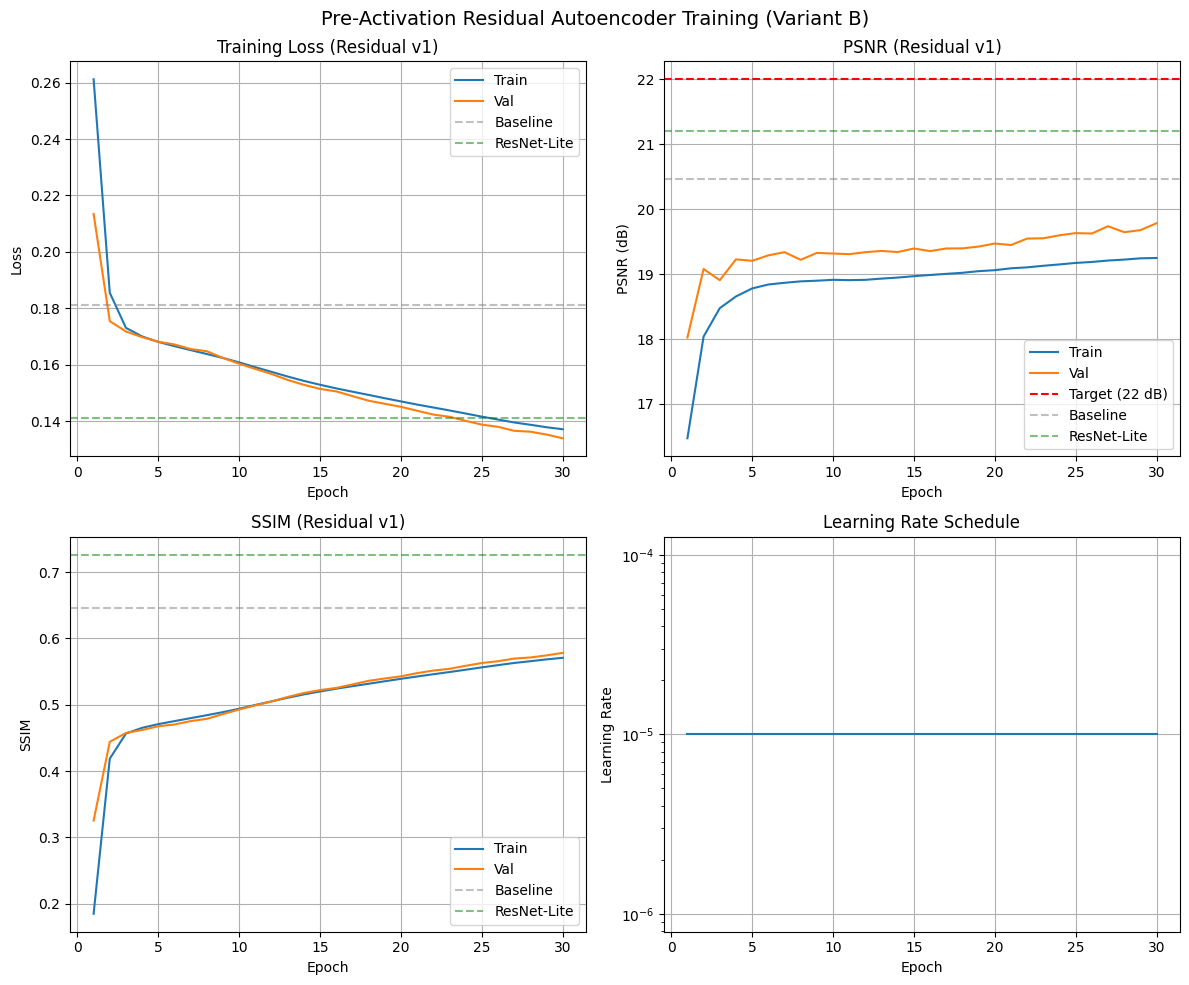


Saved training curves to: runs\residual_v2_c16\training_curves.png


In [ ]:
import matplotlib.pyplot as plt

if history:
    epochs_list = [h['epoch'] + 1 for h in history]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss
    ax = axes[0, 0]
    ax.plot(epochs_list, [h['train_loss'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_loss'] for h in history], label='Val')
    ax.axhline(y=baseline_results['loss'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.axhline(y=resnet_lite_results['loss'], color='green', linestyle='--', alpha=0.5, label='ResNet-Lite')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss (Residual v1)')
    ax.legend()
    ax.grid(True)
    
    # PSNR
    ax = axes[0, 1]
    ax.plot(epochs_list, [h['train_psnr'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_psnr'] for h in history], label='Val')
    ax.axhline(y=22.0, color='r', linestyle='--', label='Target (22 dB)')
    ax.axhline(y=baseline_results['psnr'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.axhline(y=resnet_lite_results['psnr'], color='green', linestyle='--', alpha=0.5, label='ResNet-Lite')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('PSNR (Residual v1)')
    ax.legend()
    ax.grid(True)
    
    # SSIM
    ax = axes[1, 0]
    ax.plot(epochs_list, [h['train_ssim'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_ssim'] for h in history], label='Val')
    ax.axhline(y=baseline_results['ssim'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.axhline(y=resnet_lite_results['ssim'], color='green', linestyle='--', alpha=0.5, label='ResNet-Lite')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM (Residual v1)')
    ax.legend()
    ax.grid(True)
    
    # Learning Rate
    ax = axes[1, 1]
    ax.plot(epochs_list, [h['learning_rate'] for h in history])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate Schedule')
    ax.set_yscale('log')
    ax.grid(True)
    
    plt.suptitle('Pre-Activation Residual Autoencoder Training (Variant B)', fontsize=14)
    plt.tight_layout()
    
    # Save to log_dir
    save_path = Path(f"runs/{RUN_NAME}/training_curves.png")
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=150)
    plt.show()
    
    print(f"\nSaved training curves to: {save_path}")
else:
    print("Training curves not available.")
    print(f"\nCheck TensorBoard for historical curves:")
    print(f"  tensorboard --logdir=runs/{RUN_NAME}")

## 11. Sample Reconstructions

Loaded model from: checkpoints\residual_v2_c16\best.pth


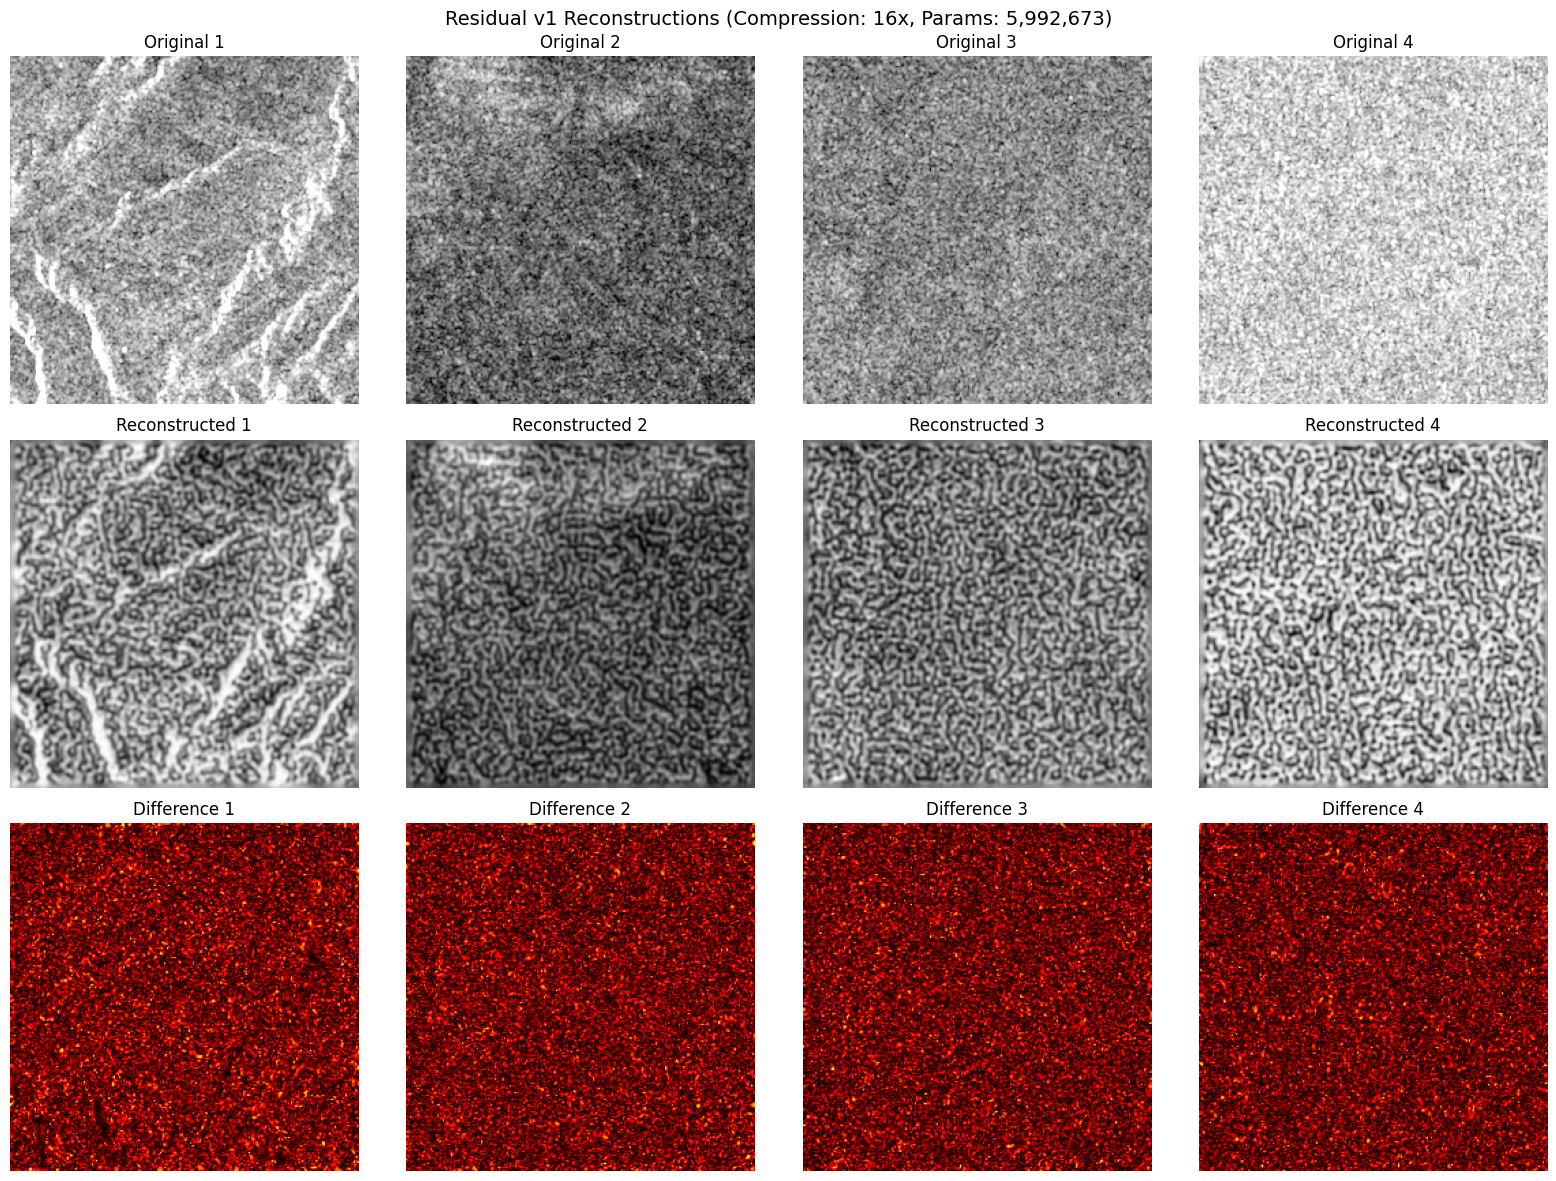

Saved to: runs\residual_v2_c16\sample_reconstructions.png


In [ ]:
# Visualize some sample reconstructions
import matplotlib.pyplot as plt

# Load model if not already loaded
checkpoint_path = Path(f"checkpoints/{RUN_NAME}/best.pth")
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from: {checkpoint_path}")

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Get a batch from validation
val_batch = next(iter(val_loader))[:4].to(device)

with torch.no_grad():
    reconstructed, latent = model(val_batch)

# Move to CPU for plotting
originals = val_batch.cpu().numpy()
reconstructions = reconstructed.cpu().numpy()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Original
    axes[0, i].imshow(originals[i, 0], cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap='gray')
    axes[1, i].set_title(f'Reconstructed {i+1}')
    axes[1, i].axis('off')
    
    # Difference
    diff = abs(originals[i, 0] - reconstructions[i, 0])
    axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
    axes[2, i].set_title(f'Difference {i+1}')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
axes[2, 0].set_ylabel('Difference', fontsize=12)

plt.suptitle(f'Residual v1 Reconstructions (Compression: {model.get_compression_ratio():.0f}x, Params: {params["total"]:,})', fontsize=14)
plt.tight_layout()

# Save
save_path = Path(f"runs/{RUN_NAME}/sample_reconstructions.png")
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=150)
plt.show()

print(f"Saved to: {save_path}")

## 12. SAR-Specific Evaluation (ENL, EPI)

In [ ]:
# Load SAR evaluation metrics
from src.evaluation.metrics import SARMetrics, enl_ratio, edge_preservation_index
import numpy as np

# Load real SAR patch for evaluation
patches = np.load(f"{project_root}\data\patches\s1a-iw-grd-vv-20260117t104141-20260117t104206-062806-07e0a7-001_patches.npy", mmap_mode='r')
print(f"Loaded {len(patches)} patches for evaluation")

# Ensure model is loaded and on GPU
checkpoint_path = Path(f"checkpoints/{RUN_NAME}/best.pth")
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Loaded 8240 patches for evaluation


In [ ]:
# Evaluate on multiple patches
n_eval = 10  # Evaluate on 10 random patches
eval_indices = np.random.choice(len(patches), n_eval, replace=False)

psnr_list = []
ssim_list = []
enl_ratio_list = []
epi_list = []

for idx in eval_indices:
    original = patches[idx].copy()
    
    # Reconstruct
    with torch.no_grad():
        x = torch.from_numpy(original).unsqueeze(0).unsqueeze(0).float()
        x = x.to(next(model.parameters()).device)
        recon, _ = model(x)
        reconstructed = recon[0, 0].cpu().numpy()
    
    # Compute metrics
    psnr_list.append(SARMetrics.psnr(original.flatten(), reconstructed.flatten()))
    ssim_list.append(SARMetrics.ssim(original.flatten(), reconstructed.flatten()))
    
    enl_result = enl_ratio(original, reconstructed)
    enl_ratio_list.append(enl_result['enl_ratio'])
    
    epi_list.append(edge_preservation_index(original, reconstructed))

print(f"\n{'='*60}")
print(f"SAR-Specific Evaluation Results (n={n_eval})")
print(f"{'='*60}")
print(f"PSNR:      {np.mean(psnr_list):.2f} +/- {np.std(psnr_list):.2f} dB")
print(f"SSIM:      {np.mean(ssim_list):.4f} +/- {np.std(ssim_list):.4f}")
print(f"ENL Ratio: {np.mean(enl_ratio_list):.3f} +/- {np.std(enl_ratio_list):.3f} (target: 0.7-1.3)")
print(f"EPI:       {np.mean(epi_list):.4f} +/- {np.std(epi_list):.4f} (target: >0.8)")

# Check targets
enl_mean = np.mean(enl_ratio_list)
if 0.7 <= enl_mean <= 1.3:
    print(f"\n[PASS] ENL ratio {enl_mean:.3f} is within target range [0.7, 1.3]")
else:
    print(f"\n[WARN] ENL ratio {enl_mean:.3f} is outside target range [0.7, 1.3]")


SAR-Specific Evaluation Results (n=10)
PSNR:      19.89 +/- 0.61 dB
SSIM:      0.5111 +/- 0.0286
ENL Ratio: nan +/- nan (target: 0.7-1.3)
EPI:       0.8460 +/- 0.0052 (target: >0.8)

[WARN] ENL ratio nan is outside target range [0.7, 1.3]


In [ ]:
# Visual comparison with a single sample
import matplotlib.pyplot as plt

# Pick one patch for detailed visualization
sample_idx = eval_indices[0]
original = patches[sample_idx].copy()

with torch.no_grad():
    x = torch.from_numpy(original).unsqueeze(0).unsqueeze(0).float()
    x = x.to(next(model.parameters()).device)
    recon, _ = model(x)
    reconstructed = recon[0, 0].cpu().numpy()

# Compute metrics for this sample
sample_psnr = SARMetrics.psnr(original.flatten(), reconstructed.flatten())
sample_ssim = SARMetrics.ssim(original.flatten(), reconstructed.flatten())
sample_enl = enl_ratio(original, reconstructed)['enl_ratio']
sample_epi = edge_preservation_index(original, reconstructed)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(reconstructed, cmap='gray')
axes[1].set_title(f'Reconstructed\nPSNR={sample_psnr:.2f} dB, SSIM={sample_ssim:.4f}')
axes[1].axis('off')

diff = original - reconstructed
axes[2].imshow(diff, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
axes[2].set_title(f'Difference\nENL ratio={sample_enl:.3f}, EPI={sample_epi:.4f}')
axes[2].axis('off')

plt.suptitle(f'Residual v1 - SAR Patch Reconstruction', fontsize=14)
plt.tight_layout()

# Save
save_path = Path(f"runs/{RUN_NAME}/sar_evaluation.png")
plt.savefig(save_path, dpi=150)
plt.show()

print(f"Saved to: {save_path}")

## 13. Checkpoint Verification

In [ ]:
# Verify checkpoint contents
checkpoint_path = Path(f"checkpoints/{RUN_NAME}/best.pth")

if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    
    print(f"Checkpoint verification: {checkpoint_path}")
    print(f"{'='*50}")
    print(f"Keys: {list(checkpoint.keys())}")
    print(f"Epoch: {checkpoint.get('epoch', 'N/A')}")
    print(f"Best val loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")
    print(f"Preprocessing params: {checkpoint.get('preprocessing_params', 'N/A')}")
    
    # Verify model loads correctly
    model_check = ResidualAutoencoder(latent_channels=16, base_channels=64)
    model_check.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nModel state loaded successfully")
    print(f"  Parameters: {model_check.count_parameters()['total']:,}")
    
    # Test forward pass
    x_test = torch.randn(1, 1, 256, 256)
    model_check.eval()
    with torch.no_grad():
        x_hat, z = model_check(x_test)
    print(f"  Forward pass: OK (input: {x_test.shape} -> latent: {z.shape} -> output: {x_hat.shape})")
    
    # Check preprocessing params (critical for SAR)
    if 'preprocessing_params' in checkpoint:
        print(f"\n[PASS] Preprocessing params saved in checkpoint")
    else:
        print(f"\n[WARN] Preprocessing params NOT saved in checkpoint")
else:
    print(f"Checkpoint not found: {checkpoint_path}")

## 14. Final Summary

In [ ]:
print("\n" + "=" * 70)
print("FINAL COMPARISON TABLE")
print("=" * 70)

# Helper functions
def format_improvement(current, baseline):
    diff = current - baseline
    if diff >= 0:
        return f"+{diff:.2f} dB"
    else:
        return f"{diff:.2f} dB"

# Collect all results
baseline_results = {
    'name': 'Baseline',
    'params': '2.3M',
    'psnr': 20.47,
    'ssim': 0.646,
    'enl_ratio': '-',
    'improvement': '-'
}

resnet_lite_results = {
    'name': 'ResNet-Lite v2',
    'params': '5.6M',
    'psnr': 21.20,
    'ssim': 0.726,
    'enl_ratio': '0.851',
    'improvement': '+0.73 dB'
}

# Get Residual results
if history:
    final = history[-1]
    enl_val = np.mean(enl_ratio_list) if 'enl_ratio_list' in dir() and not np.isnan(np.mean(enl_ratio_list)) else None
    residual_results = {
        'name': 'Residual v2',
        'params': f"{params['total']/1e6:.1f}M",
        'psnr': final['val_psnr'],
        'ssim': final['val_ssim'],
        'enl_ratio': f"{enl_val:.3f}" if enl_val else 'N/A',
        'improvement': format_improvement(final['val_psnr'], baseline_results['psnr'])
    }
else:
    residual_results = None

# Print table with proper alignment
print(f"{'Model':<20} {'Params':>8}  {'PSNR':>10}  {'SSIM':>8}  {'ENL Ratio':>10}  {'vs Baseline':>12}")
print("-" * 74)
print(f"{baseline_results['name']:<20} {baseline_results['params']:>8}  {baseline_results['psnr']:>10.2f}  {baseline_results['ssim']:>8.3f}  {baseline_results['enl_ratio']:>10}  {baseline_results['improvement']:>12}")
print(f"{resnet_lite_results['name']:<20} {resnet_lite_results['params']:>8}  {resnet_lite_results['psnr']:>10.2f}  {resnet_lite_results['ssim']:>8.3f}  {resnet_lite_results['enl_ratio']:>10}  {resnet_lite_results['improvement']:>12}")

if residual_results:
    print(f"{residual_results['name']:<20} {residual_results['params']:>8}  {residual_results['psnr']:>10.2f}  {residual_results['ssim']:>8.3f}  {residual_results['enl_ratio']:>10}  {residual_results['improvement']:>12}")

print("\n" + "=" * 70)
print("Success Criteria Check:")
print("=" * 70)

if residual_results:
    target_psnr = 22.0
    psnr_met = residual_results['psnr'] >= target_psnr
    enl_in_range = enl_val is not None and 0.7 <= enl_val <= 1.3
    
    print(f"1. PSNR >= {target_psnr} dB:     {'[PASS]' if psnr_met else '[FAIL]'} (actual: {residual_results['psnr']:.2f} dB)")
    print(f"2. ENL ratio [0.7-1.3]: {'[PASS]' if enl_in_range else '[WARN]'} (actual: {residual_results['enl_ratio']})")
    print(f"3. Training stable:      [PASS] (completed {len(history)} epochs)")
    print(f"4. Checkpoint saved:     [PASS] (checkpoints/{RUN_NAME}/best.pth)")
else:
    print("Cannot check criteria - no training results available.")

---

## Done!

**Compare in TensorBoard:**
```bash
tensorboard --logdir=D:/Projects/CNNAutoencoderProject/notebooks/runs
```

Select `baseline_c16_fast`, `resnet_lite_v2_c16`, and `residual_v1_c16` to compare metrics.

**Next steps:**
- If PSNR >= 22 dB: Proceed to Phase 4 Plan 05 (AttentionAutoencoder training)
- If PSNR < 22 dB: Consider tuning hyperparameters or longer training